In [23]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
from tqdm import tqdm
import plotly.express as px
import os
import sys

from scipy.optimize import minimize
# code to manage where are lunch the file
if str(os.getcwd()).split("/")[-1] == "notebooks":
    sys.path.insert(1, os.path.realpath(os.path.pardir))
    path_b = "../"
else:
    path_b ='./'
import config as c

In [2]:
windows = c.windows
number_crypto = c.number_cyptos
market_cap = c.market_cap

df_name_index = pd.read_csv(f"{path_b}data/processed/first_{number_crypto}_crypto_list.csv", index_col=0)
df = pd.read_csv(f"{path_b}data/processed/market_cap_crypto.csv", index_col=0)

df_close_price = pd.read_csv(f'{path_b}data/processed/close_price_crypto.csv', index_col=0)
df_close_price['date'] = pd.to_datetime(df_close_price.index)
df_close_price['date'] = df_close_price['date'].dt.date
df_close_price.index = df_close_price['date']
del df_close_price['date']

In [3]:
## use market cap file

df_market_cap = pd.read_csv(f'{path_b}data/processed/crypto_date_marketcap_sorted.csv', index_col=0)


df_market_cap_first_20 = df_market_cap.iloc[:number_crypto]

#select last date
first_date = df_market_cap_first_20['first_date_marketcap'].tail(1).values

first_date_final = pd.to_datetime(first_date[0])

df_final_data = df_close_price.drop(df_close_price[df_close_price.index < first_date_final].index)
df_final_data = df_final_data[df_market_cap_first_20['crypto_name']]
df_final_data_return = np.log(df_final_data/df_final_data.shift(1)).dropna()

/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [4]:
def MCR_calc(alloc, Returns):
    """ 
    This function computes the marginal contribution to risk (MCR), which 
    determine how much the portfolio volatility would change if we increase
    the weight of a particular asset.
    
    Parameters
    ----------
    alloc : TYPE
        Weights in the investor's portfolio
    Returns : TYPE
        The returns of the portfolio's assets
    Returns
    -------
    MCR : Object
        Marginal contribution to risk (MCR)
    """
    ptf=np.multiply(Returns,alloc)
    ptfReturns=np.sum(ptf,1); # Summing across columns
    vol_ptf=np.std(ptfReturns)
    Sigma=np.cov(np.transpose(Returns))
    MCR=np.matmul(Sigma,np.transpose(alloc))/vol_ptf
    return MCR

In [5]:
###ERC Allocation###
def ERC(alloc,Returns):
    """ 
    This function computes the Equally-Weighted Risk Contribution Portfolio (ERC),
    which attributes the same risk contribution to all the assets.
    
    Parameters
    ----------
    alloc : TYPE
        Weights in the investor's portfolio
    Returns : TYPE
        The returns of the portfolio's assets
    Returns
    -------
    criterions : Object
        Optimal weights of assets in the portfolio.
    """
    ptf=np.multiply(Returns.iloc[:,:],alloc);
    ptfReturns=np.sum(ptf,1); # Summing across columns
    vol_ptf=np.std(ptfReturns);
    indiv_ERC=alloc*MCR_calc(alloc,Returns);
    criterion=np.power(indiv_ERC-vol_ptf/len(alloc),2)
    criterion=np.sum(criterion)*1000000000
    return criterion

df_ERC = df_final_data_return
#del df_ERC['monacoin']
#adpt code to manage difference number of crypto

def optimizer_ERC(ERC_df):
    length = ERC_df.shape[1]
    x0 = np.zeros(length)+0.0001 #Set the first weights of the Gradient Descent
    #x0 = np.zeros(len(df_ERC))+0.0001

    cons=({'type':'eq', 'fun': lambda x:sum(x)-1}) #Sum of weights is equal to 1

    Bounds= [(0 , 1) for i in range(0,length)] #Long only positions


    #Optimisation
    res_ERC = minimize(ERC, x0, method='SLSQP', args=(ERC_df),bounds=Bounds,constraints=cons,options={'disp': False})
    return res_ERC.x

windows = 120

weights_ERC = []
for i in tqdm(range(df_ERC.shape[0])):
    cov_matrix = df_ERC.iloc[i:windows+i]
    weight = optimizer_ERC(cov_matrix)
    weights_ERC.append(weight)


  0%|          | 0/1884 [00:00<?, ?it/s]/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
  0%|          | 1/1884 [00:00<14:57,  2.10it/s]/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
100%|█████████▉| 1883/1884 [1:06:39<00:02,  2.63s/it]/var/folders/hv/kjs_mg3s28b_rhljhxq6r2f80000gp/T/ipykernel_49871/3296709344.py:21: RuntimeWarning: Degrees of freedom <= 0 for slice
  Sigma=np.cov(np.transpose(Returns))
/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/guillaume/MyProjects/HECProject/qarm_2/project/ve

In [13]:
df_port_ERC = pd.DataFrame(weights_ERC)
df_port_ERC.columns = df_final_data_return.columns
df_port_ERC.index = df_final_data_return.index
df_port_ERC.head(4)


,bitcoin,litecoin,ripple,nxt,dogecoin,digibyte,dash,monero,bitshares,stellar,verge,nem,ethereum,siacoin,decred,lisk,digixdao,steem,bytecoin-bcn,augur
date,,,,,,,,,,,,,,,,,,,,
2016-05-15,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100
2016-08-22,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100
2016-08-23,0.148621,0.129308,0.043256,0.053002,0.125841,0.038756,0.067209,0.028652,0.035965,0.022489,0.017538,0.035155,0.038924,0.028622,0.049169,0.034616,0.040961,0.024835,0.026494,0.010587
2016-08-24,0.144196,0.125698,0.044029,0.053247,0.122861,0.038286,0.071403,0.028231,0.036594,0.022864,0.017732,0.037860,0.038833,0.028944,0.051013,0.034323,0.040976,0.025570,0.026665,0.010674


Text(0.5, 1.0, 'Risk Parity weight')

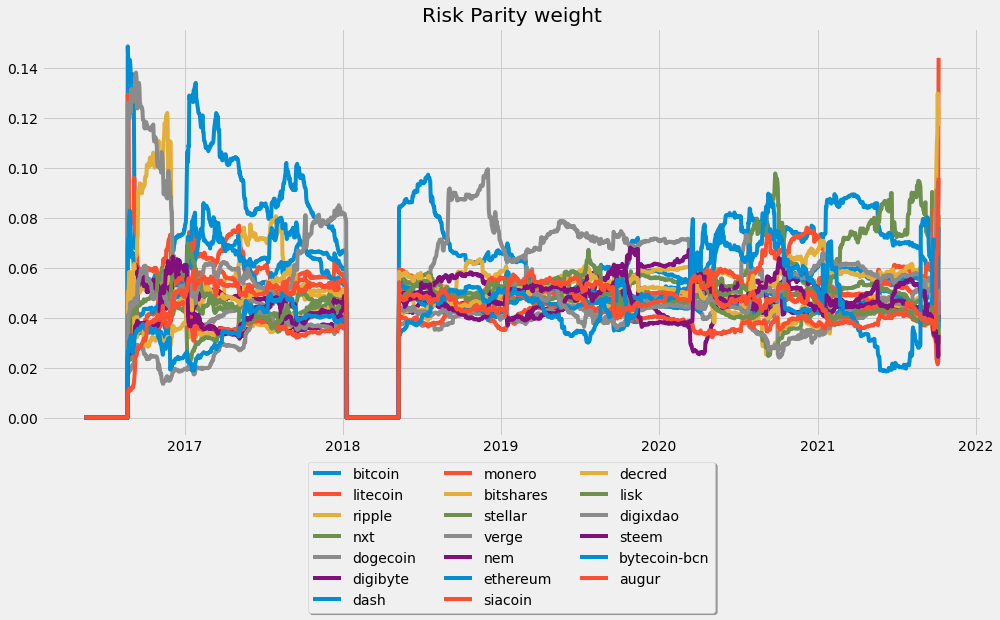

In [16]:
plt.figure(figsize=(15,7))
plt.plot(df_port_ERC.iloc[:-10]) ## problem avec le début et les dernières périodes
plt.legend(df_port_ERC.columns, loc="lower center", fancybox=True, shadow=True,ncol=3,bbox_to_anchor=(0.5, -0.45))
plt.title("Risk Parity weight")

In [24]:
fig = px.line(df_port_ERC, x=df_port_ERC.index, y=df_port_ERC.columns, title="Risk Parity (Evolution of weights)") #bug à la fin
fig.show()

In [26]:
portfolio_erc = np.sum(np.multiply(df_final_data_return, df_port_ERC),1)[2:]
portfolio_erc = portfolio_erc.drop(portfolio_erc[portfolio_erc.index == pd.to_datetime("2018-05-09") ].index)
portfolio_erc = portfolio_erc.drop(portfolio_erc[portfolio_erc.index == pd.to_datetime("2018-05-10") ].index)
portfolio_erc

date
2016-08-23   -0.009323
2016-08-24   -0.005716
2016-08-25   -0.007144
2016-08-26    0.008612
2016-08-27   -0.020064
                ...   
2021-10-13    0.015288
2021-10-14   -0.005521
2021-10-15    0.014484
2021-10-16    0.026676
2021-10-17    0.000004
Length: 1880, dtype: float64

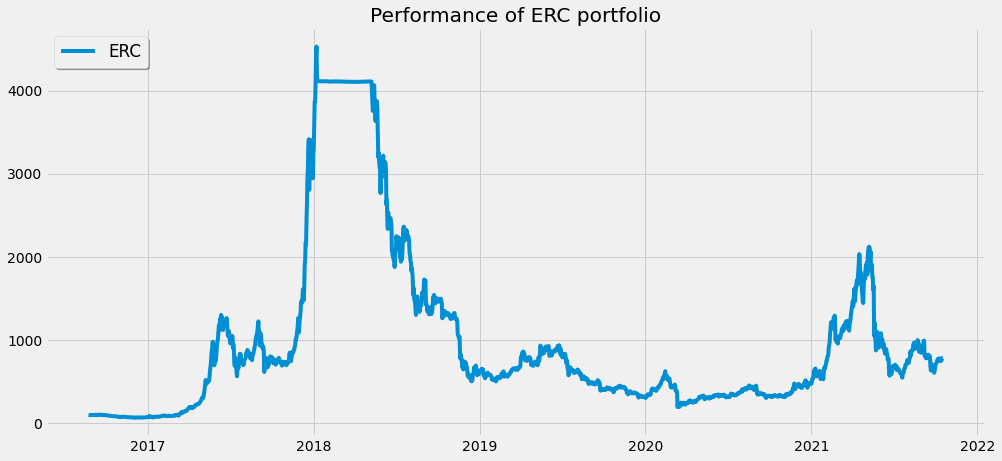

In [27]:
#bug avec les dernières dates
plt.figure(figsize=(15,7))
plt.plot((portfolio_erc+1).cumprod()*100)
plt.legend(['ERC'],loc='upper left',fontsize='large',fancybox=True, shadow=True)
plt.title('Performance of ERC portfolio')
plt.show()

In [25]:
portfolio_erc.drop(portfolio_erc[portfolio_erc.index < pd.to_datetime("2018-05-06") ].index)

/Users/guillaume/MyProjects/HECProject/qarm_2/project/venv/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



date
2018-05-06   -0.000059
2018-05-07   -0.000076
2018-05-08    0.000139
2018-05-09        -inf
2018-05-10         inf
                ...   
2021-10-13    0.015288
2021-10-14   -0.005521
2021-10-15    0.014484
2021-10-16    0.026676
2021-10-17    0.000004
Length: 1261, dtype: float64